# Lab 4: BBC News Classification
<strong>Author:</strong> Josiah Ball<br>
<strong>Submission Date:</strong> 3/1/2025<br>
<strong>Course:</strong> DTSA 5510 Unsupervised Algorithms in Machine Learning

# Overview
In this notebook, I will take a dataset of BBC News articles provided in the "BBC News Classification" Kaggle competition[1] and use matrix factorization to predict the category (business, tech, sports, etc.). Then, we will compare the performance of the unsupervised matrix factorization method against a supervised learning method (in my case, Random Forest). In order to accomplish this, I will conduct the following steps:
<ol>
    <li>Perform EDA on the dataset</li>
    <li>Build Initial Models and Compare SVD versus NMF Using Training Dataset</li>
    <li>Optimize the Hyperparameters of the Better Model on the Training Dataset</li>
    <li>Train the Random Forest (Supervised Learning) Model</li>
    <li>Compare Results of Unsupervised versus Supervised Leaning Models on the Testing Dataset</li>
</ol>

## Step 1: Perform EDA
<strong>DISCUSSION:</strong> As with any project, the first step is to understand the problem and understand the data. I will be generally following the EDA steps from this article:[2]<br>
<a href="https://www.geeksforgeeks.org/steps-for-mastering-exploratory-data-analysis-eda-steps/" target="_blank">https://www.geeksforgeeks.org/steps-for-mastering-exploratory-data-analysis-eda-steps/</a>

In [55]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# EDA Step 1: Understand the Problem

<strong>DISCUSSION:</strong> As mentioned above, the goal of this lab is to take a dataset of BBC News articles provided in the "BBC News Classification" Kaggle competition[3] and use matrix factorization to accurately predict the 
category (business, tech, sports, etc.) of unseen test articles. Then, we will compare the performance of the unsupervised 
matrix factorization method against a supervised learning method (in my case, XGBoost).

In [140]:
# EDA Step 2: Upload and Inspect the Data
df_train = pd.read_csv("BBC_Train.csv")
df_test = pd.read_csv("BBC_Test.csv")

In [6]:
print(df_train.info())
print(df_train.nunique())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
ArticleId    1490
Text         1440
Category        5
dtype: int64


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [7]:
print(df_test.info())
print(df_test.nunique())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
ArticleId    735
Text         722
dtype: int64


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [8]:
# EDA Step 3: Handle NaN Values

In [9]:
df_train.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [10]:
df_test.isna().sum()

ArticleId    0
Text         0
dtype: int64

<strong>DISCUSSION:</strong> Both datasets are free of null values, eliminating the need for null exception handling.

In [12]:
# EDA Step 4: Explore Data Chracteristics
print(df_train['Category'].value_counts(normalize=True))

Category
sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: proportion, dtype: float64


<strong>DISCUSSION:</strong> These classes are relatively well-balanced, so no data transformations, undersampling/oversampling, or learning penalties for minority class misclassifications are necessary.

Text(0.5, 1.0, 'Histogram of Category Counts')

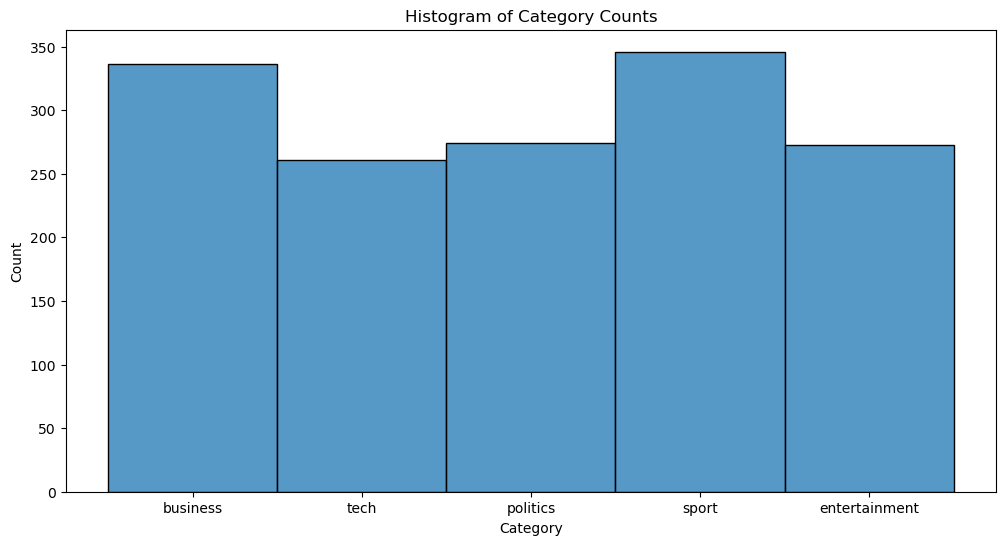

In [14]:
# EDA Step 5: Visualize the Data
fig, axes = plt.subplots(figsize=(12, 6))
sns.histplot(df_train['Category'])
axes.set_title('Histogram of Category Counts')

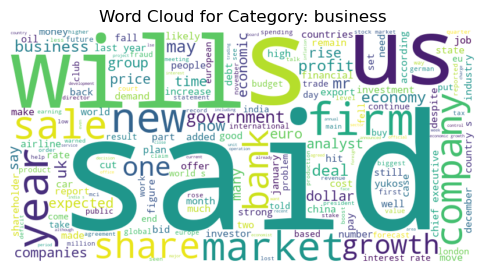

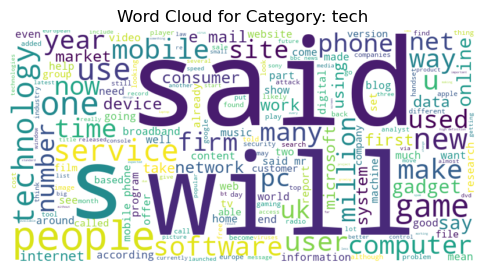

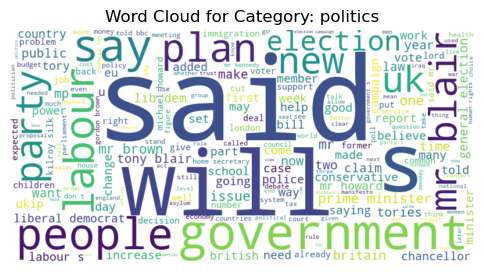

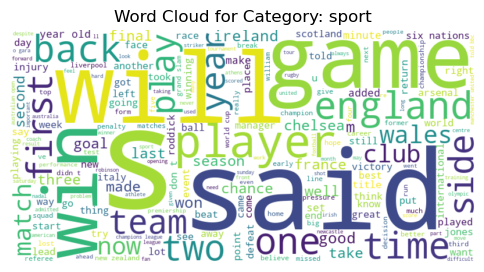

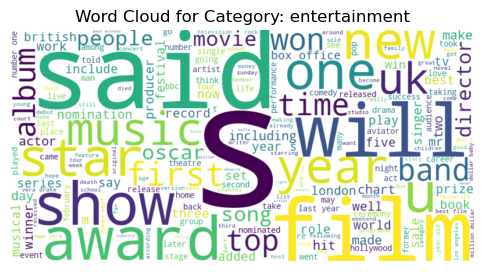

In [16]:
stopwords = set(STOPWORDS)

def generate_wordclouds(df, category_col, text_col):
    categories = df[category_col].unique()
    
    for category in categories:
        # Concatenate all text in the same category
        text_data = " ".join(df[df[category_col] == category][text_col])
        
        # Generate word cloud
        wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(text_data)
        
        # Plot word cloud
        plt.figure(figsize=(6, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Category: {category}')
        plt.show()

# Generate Word Clouds for Each Category
generate_wordclouds(df_train, 'Category', 'Text')

<strong>DISCUSSION:</strong> This is a very clean and useable dataset. There are no missing values, the classes are generally balanced, and there is no noise of unnecessary variables.<br>
<br>
To vectorize the article text, we will use term-frequency inverse-document-frequency (TF-IDF), since this method was explicitly referenced in sklearn's library on <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html" target="_blank">Singular Value Decomposition (SVD) matrix factorization</a>[4]. SVD works particularly well with TF-IDF because TF-IDF returns sparse matricies with lots of zeroes, and SVD does not center the data prior to computing (unlike PCA)[5]. In this context, it is called "Latent Semantic Analysis" (LSA)[6]. One downside to using TF-IDF is that we likely cannot use Non-Negative Matrix Factorization (NMF), because of the possibility of introducing negative numbers due to the inherant error of NMF. <br>
<br>
We will proceed as follows:<br>
<ol>
    <li>Use TF-IDF to vectorize the text</li>
    <li>Build initial model using SVD matrix factorization</li>
    <li>Evaluate the Accuracy of the initial model</li>
</ol>

# Step 2: Build Initial Models and Compare SVD versus NMF

<strong>DISCUSSION:</strong> Should we use the training data only, or test and training data? I will be using only the training data to train the unsupervised learning model for two reasons: 1) while it is true that the labels do not matter when training an unsupervised model, that does not mean that data leakage is not an issue. The goal in any predictive model is to be able to accurately predict new samples which have never been seen by the model, so if we train with the testing dataset then we will not have an accurate understanding of how the model performs with unseen data. 2) Training both the supervised and unsupervised models with training dataset and testing on the testing dataset ensures a fair comparison.

### Use TF-IDF to vectorize the text

In [24]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
corpus = df_train['Text']
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
dense_list = dense.tolist()
vectors_df = pd.DataFrame(dense_list, columns=feature_names)
df_train['TF-IDF Vector'] = dense_list
df_train.head()

,ArticleId,Text,Category,TF-IDF Vector
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,154,german business confidence slides german busin...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[0.0, 0.023202386888365765, 0.0, 0.0, 0.0, 0.0..."
3,1976,lifestyle governs mobile choice faster bett...,tech,"[0.0, 0.01944598302525407, 0.0, 0.0, 0.0, 0.0,..."
4,917,enron bosses in $168m payout eighteen former e...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<strong>DISCUSSION:</strong> We will create and test two different methods of matrix factorization: Non-Negative Matrix Factorization (NMF) and Singular Value Decomposition (SVD) matrix factorization.

### Train Initial Non-Negative Matrix Factorization (NMF) Model

In [31]:
nmf = NMF(n_components=5, random_state=42)
nmf_model = nmf.fit_transform(df_train['TF-IDF Vector'].tolist())
df_train['NMF Prediction'] = nmf_model.argmax(axis=1)
df_train.head()

,ArticleId,Text,Category,TF-IDF Vector,NMF Prediction
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
1,154,german business confidence slides german busin...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[0.0, 0.023202386888365765, 0.0, 0.0, 0.0, 0.0...",4
3,1976,lifestyle governs mobile choice faster bett...,tech,"[0.0, 0.01944598302525407, 0.0, 0.0, 0.0, 0.0,...",2
4,917,enron bosses in $168m payout eighteen former e...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4


In [33]:
# Display top words for each topic
terms = vectorizer.get_feature_names_out()
topic_words = {}

for i, topic in enumerate(nmf.components_):
    top_words = [terms[j] for j in topic.argsort()[:-11:-1]]  # Get top 10 words
    topic_words[f"Topic {i}"] = top_words

topic_df = pd.DataFrame(topic_words)
print("Top words per topic:")
print(topic_df)

Top words per topic:
   Topic 0     Topic 1     Topic 2   Topic 3   Topic 4
0  england          mr      mobile      film    growth
1     game      labour      people      best   economy
2      win    election       music    awards      said
3    wales       blair       phone     award  economic
4  ireland       brown        said     actor      year
5      cup       party     digital   actress      bank
6     said        said      phones     oscar     sales
7     team  government  technology       won    dollar
8     play    minister       users  director       oil
9  players      howard   broadband     films    market


<strong>DISCUSSION: </strong>We can infer from these results that topic 0 maps to sport, topic 1 to politics, topic 2 to tech, topic 3 to entertainment, and topic 4 to business.

In [35]:
mapping = {0: 'sport',
           1: 'politics',
           2: 'tech',
           3: 'entertainment',
           4: 'business'}
def map_topic(value):
    return mapping.get(value, 'Unknown')
df_train['NMF Prediction Topic'] = df_train['NMF Prediction'].map(map_topic)
df_train.head()

,ArticleId,Text,Category,TF-IDF Vector,NMF Prediction,NMF Prediction Topic
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business
1,154,german business confidence slides german busin...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[0.0, 0.023202386888365765, 0.0, 0.0, 0.0, 0.0...",4,business
3,1976,lifestyle governs mobile choice faster bett...,tech,"[0.0, 0.01944598302525407, 0.0, 0.0, 0.0, 0.0,...",2,tech
4,917,enron bosses in $168m payout eighteen former e...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business


### Calculate Accuracy and Confusion Matrix of NMF Model

In [37]:
print(classification_report(df_train['Category'].tolist(),df_train['NMF Prediction Topic'].tolist()))

               precision    recall  f1-score   support

     business       0.91      0.93      0.92       336
entertainment       0.97      0.79      0.87       273
     politics       0.92      0.89      0.91       274
        sport       0.97      0.99      0.98       346
         tech       0.81      0.96      0.88       261

     accuracy                           0.92      1490
    macro avg       0.92      0.91      0.91      1490
 weighted avg       0.92      0.92      0.92      1490



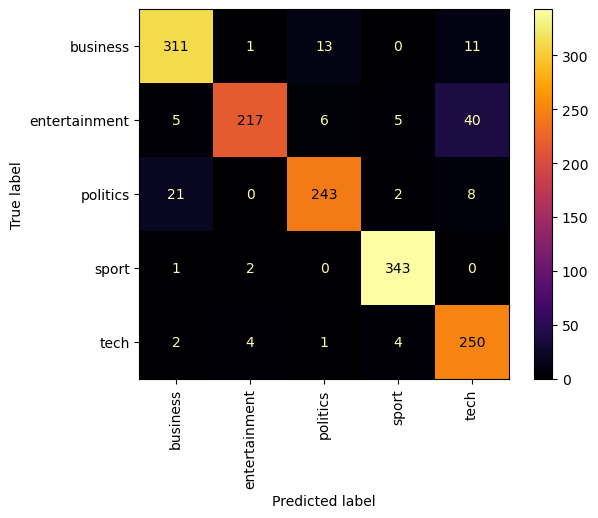

In [38]:
unique_labels = sorted(df_train['Category'].unique())
cm = confusion_matrix(df_train['Category'].tolist(),df_train['NMF Prediction Topic'].tolist(), labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='inferno', xticks_rotation='vertical')
plt.show()

### Train Initial SVD Matrix Factorization Model

In [40]:
# Fit SVD Model
SVD = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
SVD.fit_transform(df_train['TF-IDF Vector'].tolist())
SVD

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [41]:
topic_distributions = SVD.transform(df_train['TF-IDF Vector'].tolist())
df_train['SVD Prediction'] = np.argmax(topic_distributions, axis=1)
df_train.head()

,ArticleId,Text,Category,TF-IDF Vector,NMF Prediction,NMF Prediction Topic,SVD Prediction
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business,0
1,154,german business confidence slides german busin...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[0.0, 0.023202386888365765, 0.0, 0.0, 0.0, 0.0...",4,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,"[0.0, 0.01944598302525407, 0.0, 0.0, 0.0, 0.0,...",2,tech,2
4,917,enron bosses in $168m payout eighteen former e...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business,0


In [42]:
# Display top words for each topic
terms = vectorizer.get_feature_names_out()
topic_words = {}

for i, topic in enumerate(SVD.components_):
    top_words = [terms[j] for j in topic.argsort()[:-11:-1]]  # Get top 10 words
    topic_words[f"Topic {i}"] = top_words

topic_df = pd.DataFrame(topic_words)
print("Top words per topic:")
print(topic_df)

Top words per topic:
      Topic 0     Topic 1    Topic 2   Topic 3   Topic 4
0        said      labour     mobile      film    growth
1          mr          mr      phone      best   economy
2      labour    election     people    awards  economic
3      people       blair     phones     award    dollar
4    election       brown      music     actor      bank
5        year       party     growth   actress       oil
6       blair         tax      users     oscar     rates
7         new  government    digital     films     sales
8  government    minister  broadband  director     china
9       brown       prime     market   aviator   deficit


<strong>DISCUSSION:</strong> SVD failed to properly distinguish between politics and sports, so it is returning politics for both topics 1 and 1. We will adjust our topic mapping accordingly.

In [43]:
svd_mapping = {0: 'politics',
           1: 'politics',
           2: 'tech',
           3: 'entertainment',
           4: 'business'}
def map_topic(value):
    return mapping.get(value, 'Unknown')
df_train['SVD Prediction Topic'] = df_train['SVD Prediction'].map(svd_mapping)
df_train.head()

,ArticleId,Text,Category,TF-IDF Vector,NMF Prediction,NMF Prediction Topic,SVD Prediction,SVD Prediction Topic
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business,0,politics
1,154,german business confidence slides german busin...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business,4,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[0.0, 0.023202386888365765, 0.0, 0.0, 0.0, 0.0...",4,business,0,politics
3,1976,lifestyle governs mobile choice faster bett...,tech,"[0.0, 0.01944598302525407, 0.0, 0.0, 0.0, 0.0,...",2,tech,2,tech
4,917,enron bosses in $168m payout eighteen former e...,business,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,business,0,politics


               precision    recall  f1-score   support

     business       1.00      0.28      0.43       336
entertainment       0.99      0.37      0.54       273
     politics       0.22      1.00      0.37       274
        sport       0.00      0.00      0.00       346
         tech       0.99      0.26      0.42       261

     accuracy                           0.36      1490
    macro avg       0.64      0.38      0.35      1490
 weighted avg       0.62      0.36      0.34      1490



C:\Users\Public\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


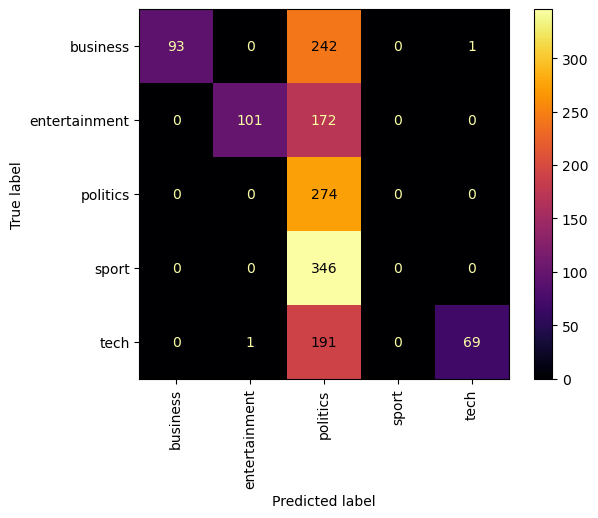

In [44]:
print(classification_report(df_train['Category'].tolist(),df_train['SVD Prediction Topic'].tolist()))
unique_labels = sorted(df_train['Category'].unique())
cm = confusion_matrix(df_train['Category'].tolist(),df_train['SVD Prediction Topic'].tolist(), labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='inferno', xticks_rotation='vertical')
plt.show()

<strong>DISCUSSION:</strong> Note how SVD disproportionately predicted politics the vast majority of the time, in part due to it predicting politics for both topics 0 and 1. 

<strong>DISCUSSION:</strong> Because NMF vastly outperformed SVD (accuracy of 92% compared to 36%), we will move forward with NMF for hyperparameter tuning.

# Step 3: NMF Hyperparameter Tuning

In [51]:
# Define Accuracy Function to Use in GridSearchCV
import warnings
warnings.filterwarnings("ignore")
def calc_accuracy(estimator, X, y):
    topic_distribution = estimator.transform(X)
    y_pred_indices = topic_distribution.argmax(axis=1)  # Get the predicted topic index
    y_pred_topics = np.array([map_topic(idx) for idx in y_pred_indices])  # Map to topic names
    return accuracy_score(y, y_pred_topics)

# Define Model and Parameters
nmf = NMF(random_state=42, max_iter=500)
parameters = {
    'n_components':[5], 
    'solver':['cd','mu'],
    'alpha_W': [0.0, 0.25, 0.5],
    'alpha_H': [0.0, 0.25, 0.5],
    'l1_ratio': [0.0, 0.25, 0.5]
}

# Fit and Perform Grid Search
GridSearch_Model = GridSearchCV(estimator=nmf, param_grid=parameters, scoring=calc_accuracy,cv=3)
GridSearch_Model.fit(df_train['TF-IDF Vector'].tolist(),df_train['Category'].tolist())

GridSearchCV(cv=3, estimator=NMF(max_iter=500, random_state=42),
             param_grid={'alpha_H': [0.0, 0.25, 0.5],
                         'alpha_W': [0.0, 0.25, 0.5],
                         'l1_ratio': [0.0, 0.25, 0.5], 'n_components': [5],
                         'solver': ['cd', 'mu']},
             scoring=<function calc_accuracy at 0x0000016BCC8C8D60>)

               precision    recall  f1-score   support

     business       0.91      0.93      0.92       336
entertainment       0.97      0.79      0.87       273
     politics       0.92      0.89      0.91       274
        sport       0.97      0.99      0.98       346
         tech       0.81      0.96      0.88       261

     accuracy                           0.92      1490
    macro avg       0.92      0.91      0.91      1490
 weighted avg       0.92      0.92      0.92      1490



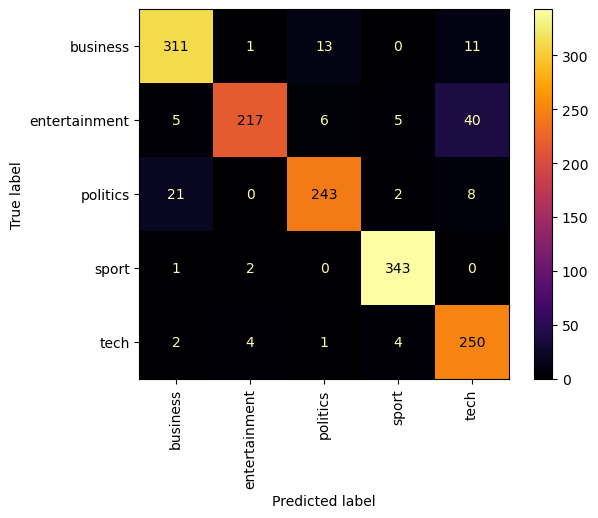

In [60]:
# Calculate Results with Best estimators
best_nmf = GridSearch_Model.best_estimator_
best_nmf_fit = best_nmf.fit_transform(df_train['TF-IDF Vector'].tolist())
df_train['Best NMF Prediction'] = best_nmf_fit.argmax(axis=1)
df_train['Best NMF Prediction Topic'] = df_train['Best NMF Prediction'].map(map_topic)
print(classification_report(df_train['Category'].tolist(),df_train['Best NMF Prediction Topic'].tolist()))
unique_labels = sorted(df_train['Category'].unique())
cm = confusion_matrix(df_train['Category'].tolist(),df_train['Best NMF Prediction Topic'].tolist(), labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='inferno', xticks_rotation='vertical')
plt.show()

# Step 4: Train the Random Forest (Supervised Learning) Model

In [67]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(df_train['TF-IDF Vector'].tolist(), df_train['Category'].tolist())
y_pred = rf_classifier.predict(df_train['TF-IDF Vector'].tolist())
print(classification_report(df_train['Category'].tolist(), y_pred))

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       336
entertainment       1.00      1.00      1.00       273
     politics       1.00      1.00      1.00       274
        sport       1.00      1.00      1.00       346
         tech       1.00      1.00      1.00       261

     accuracy                           1.00      1490
    macro avg       1.00      1.00      1.00      1490
 weighted avg       1.00      1.00      1.00      1490



<strong>DISCUSSION:</strong> It is no surprise that the supervised learning model performed perfectly on the training dataset, and this does not tell us anything about the performance of the model. We must test on the testing dataset to understand the model's true performance.

In [71]:
n_predictors = len(df_train['TF-IDF Vector'][0])
sqrt_n_predictors = round(math.sqrt(n_predictors))
min_predictors = sqrt_n_predictors - 50
max_predictors = sqrt_n_predictors + 50
rf_parameters = {
    'n_estimators':[min_predictors,max_predictors], 
    'max_depth': [5,10,15,20]
}
GridSearch_Model_RF = GridSearchCV(estimator=rf_classifier, param_grid=rf_parameters,cv=3)
GridSearch_Model_RF.fit(df_train['TF-IDF Vector'].tolist(),df_train['Category'].tolist())
best_rf = GridSearch_Model_RF.best_estimator_

# Step 5: Compare Results of Unsupervised versus Supervised Leaning Models on the Testing Dataset

In [120]:
def tfidf_vectorization(df_train,df_test):
    vectorizer = TfidfVectorizer(stop_words='english')
    vectors_train = vectorizer.fit_transform(df_train['Text'])
    vectors_test = vectorizer.transform(df_test['Text'])
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors_test.todense()
    dense_list = dense.tolist()
    vectors_df = pd.DataFrame(dense_list, columns=feature_names)
    df_test['TF-IDF Vector'] = dense_list
    return df_test

def nmf_predict(df_test, best_nmf):
    best_nmf_fit = best_nmf.fit_transform(df_test['TF-IDF Vector'].tolist())
    df_test['Best NMF Prediction'] = best_nmf_fit.argmax(axis=1)
    df_test['Category'] = df_test['Best NMF Prediction'].map(map_topic)
    df_test = df_test[['ArticleId','Category']]
    return df_test

def rf_predict(df_test, best_rf):
    df_test['Category'] = best_rf.predict(df_test['TF-IDF Vector'].tolist())
    df_test = df_test[['ArticleId','Category']]
    return df_test

In [142]:
df_test_vector = tfidf_vectorization(df_train=df_train,df_test=df_test)
df_test_vector.head()

,ArticleId,Text,TF-IDF Vector
0,1018,qpr keeper day heads for preston queens park r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1319,software watching while you work software that...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1138,d arcy injury adds to ireland woe gordon d arc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,459,india s reliance family feud heats up the ongo...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1020,boro suffer morrison injury blow middlesbrough...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [144]:
nmf_solution = nmf_predict(df_test=df_test_vector, best_nmf=best_nmf)
nmf_solution.head()

,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,tech
4,1020,sport


In [146]:
nmf_solution.to_csv("nmf_solution.csv",index=False)

<strong>ACCURACY ON TEST DATA:</strong> 41%

In [149]:
rf_solution = rf_predict(df_test=df_test, best_rf=best_rf)
rf_solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [150]:
rf_solution.to_csv("rf_solution.csv",index=False)

<strong>ACCURACY ON TEST DATA:</strong> 96%

<strong>DISCUSSION:</strong> It is clear that the supervised learning model performed far, far better than the unsupervised learning method. The random forest model produced an accuracy of 96% when predicting the topic of the test dataset, while the non-negative matrix factorization model had an accuracy of 41%. Regarding overfitting, we consider a model to be overfit when the model has low bias (performs well on the training dataset) and high variance (performs poorly on the testing dataset. In our case, it is clear that the unsupervised learning model (NMF) has lower bias and much higher variance, and thus it is more overfit than the supervised learning method. There would have to be more data for the unsupervised model to increase its performance, and thus the supervised model was more efficient at producing effective results with the data given. 

## Works Cited
[1] Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.<br>
[2] Steps for Mastering Exploratory Data Analysis | EDA Steps. https://www.geeksforgeeks.org/steps-for-mastering-exploratory-data-analysis-eda-steps/, 2024. GeeksforGeeks.<br>
[3] Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.<br>
[4] TruncatedSVD. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html, accessed 2025. Scikit-learn.<br>
[5] TruncatedSVD. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html, accessed 2025. Scikit-learn.<br>
[6] TruncatedSVD. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html, accessed 2025. Scikit-learn.